In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
path='/content/Dataset of male & female BD Cricketers.csv'
stopwords_list = path+'bangla_stopwords.txt'
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
# Read the dataset
data = pd.read_csv('/content/Dataset of male & female BD Cricketers.csv',encoding='UTF-8')
data.head()

,Comment,Sentiment,Like,Haha,Angry,Love,Care,Sad,Wow
0,হায়রে ধান্দাবাজ \nপাবলিকের ইমোশন নিয়ে খেলা,Negative,103,420,89,8,2,4,0
1,আমি জানতাম এই রকম কিছু হবে কারণ বাংলাদেশের মা...,Neutral,43,161,0,2,1,0,0
2,জানতাম এটাই বলবেন,Neutral,4,6,0,0,0,0,0
3,নাটক তো ভালোই সিখছেন,Neutral,12,13,0,0,0,0,0
4,ভাই আমি তো বিকাশ চালাই,Positive,9,33,1,1,0,0,0


In [ ]:
print("Total Comment:",len(data),
      "\nTotal  Positive Comment:",len(data[data.Sentiment =='Positive']),
      "\nTotal Neutral Comment:",len(data[data.Sentiment=='Neutral']),
      "\nTotal Negative Comment:",len(data[data.Sentiment=='Negative']))

Total Comment: 7083 
Total  Positive Comment: 4571 
Total Neutral Comment: 1363 
Total Negative Comment: 1149


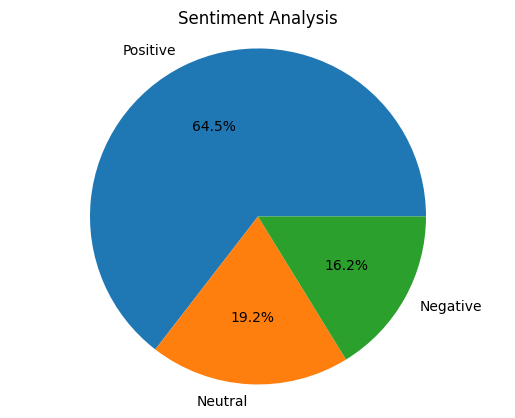

In [ ]:
data_sentiment = data[data['Sentiment'] == True]
sentiment_counts = data['Sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Analysis')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
# Show the plot
plt.show()

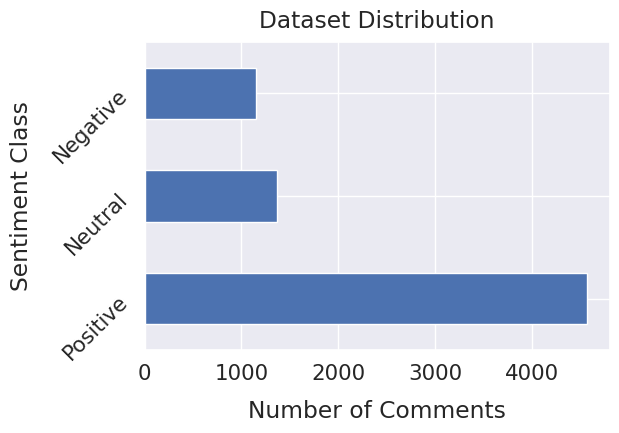

In [ ]:
sns.set(font_scale=1.4)
data['Sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [ ]:
# print some unprocessed reviews
sample_data = [10,100,150,1300,]
for i in sample_data:
      print(data.Comment[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

আর কত্ত খেলবো 
 Sentiment:--  Positive 

অভিনন্দন 
 Sentiment:--  Positive 

জানাচ্ছি 
 Sentiment:--  Positive 

ভাই জিতান এই ম্যাচ টা দয়া করে 
 Sentiment:--  Positive 



In [ ]:
# Data cleaning function
def process_comments(comment):
    comment = re.sub('[^\u0980-\u09FF]',' ',str(comment)) #removing unnecessary punctuation
    return comment

In [ ]:
import pandas as pd
data['cleaned'] = ''
# Apply the function into the dataframe
data['cleaned'] = data['Comment'].apply(process_comments)

# print some cleaned comment from the dataset
sample_data = [10,100,150,1300]
for i in sample_data:
     print('Original:\n',data.Comment[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

Original:
 আর কত্ত খেলবো 
Cleaned:
 আর কত্ত খেলবো 
 Sentiment:--  Positive 

Original:
 অভিনন্দন 
Cleaned:
 অভিনন্দন 
 Sentiment:--  Positive 

Original:
 জানাচ্ছি 
Cleaned:
 জানাচ্ছি 
 Sentiment:--  Positive 

Original:
 ভাই জিতান এই ম্যাচ টা দয়া করে 
Cleaned:
 ভাই জিতান এই ম্যাচ টা দয়া করে 
 Sentiment:--  Positive 



In [ ]:
# Length of each Comment
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the comment with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Comment".format(len(data)-len(dataset)),
      "\nTotal Comment:",len(dataset))


After Cleaning: 
Removed 926 Small Comment 
Total Comment: 6157


In [ ]:
def data_summary(dataset):

    """
    This function will print the summary of the reviews and words distribution in the dataset.

    Args:
        dataset: list of cleaned sentences

    Returns:
        Number of documnets per class: int
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Sentiment.value_counts().to_dict().items()]
  # find word list
    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.Sentiment==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Sentiment==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Sentiment==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Positive
Number of Documents:3977
Number of Words:34502
Number of Unique Words:6262
Most Frequent Words:

ভাই	708
আপনার	359
না	341
ভালো	302
জন্য	301
অনেক	280
হবে	253
সাকিব	235
আপনি	230
আর	221

Class Name :  Neutral
Number of Documents:1143
Number of Words:10114
Number of Unique Words:3440
Most Frequent Words:

না	211
আমার	108
কি	106
করে	103
ভাই	95
আপু	95
এই	83
আপনার	83
আপনি	73
আমি	67

Class Name :  Negative
Number of Documents:1037
Number of Words:11803
Number of Unique Words:3690
Most Frequent Words:

না	273
ভাই	136
আর	119
করে	118
এই	91
আপনি	86
আপনার	78
থেকে	74
তামিম	72
কি	68
Total Number of Unique Words:9362


<ipython-input-11-46daabb39e01>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(class_names, rotation=45);


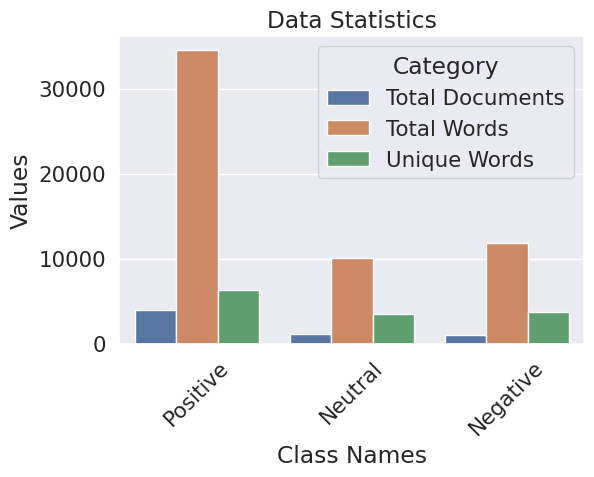

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(6, 4))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

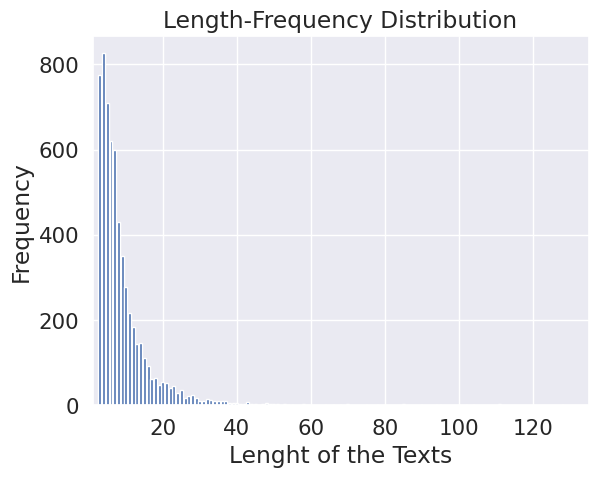

Maximum Length of a comment: 139
Minimum Length of a comment: 3
Average Length of a comment: 9.0


In [ ]:
# Calculate the Review of each of the Review
dataset['CommentLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.CommentLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.CommentLength)}")
print(f"Minimum Length of a comment: {min(dataset.CommentLength)}")
print(f"Average Length of a comment: {round(np.mean(dataset.CommentLength),0)}")

In [ ]:
dataset.Sentiment = dataset.Sentiment.replace({'Neutral':'Positive'})
positive = dataset[dataset.Sentiment == 'Positive']
negative = dataset[dataset.Sentiment == 'Negative'][:4000]
dataset = positive.append(negative,ignore_index=True)
dataset.Sentiment.value_counts()


<ipython-input-14-4b66a9ca1beb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = positive.append(negative,ignore_index=True)


Positive    5120
Negative    1037
Name: Sentiment, dtype: int64

In [ ]:
  ################# Label Encoding Function #########


def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format.

    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)

    Returns:
        labels: numpy array
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels




                           ################# Dataset Splitting Function ###############


def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector .

    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array)

    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.7,
                                                  test_size = 0.3,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])

    return X_train,X_test,y_train,y_test
dataset.cleaned = dataset.cleaned.apply(lambda x:x.replace('\n',' '))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

In [ ]:
   #########  Classifiers Defination  #########

def ml_models_defination():
    """
    This function consists the models defination for All gram Features

    Retuns:
        ml_models: list of models
        model_names: list of model_names

    """

    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    xgboost_model= XGBClassifier(n_estimators=100, learning_rate=0.01)
    adabost_model=AdaBoostClassifier()
    ann_model=MLPClassifier()

    model_names = ['Logistic Regression','Decision Tree','Random Forest','KNN','Linear SVM','XGBoost','Adabost','ANN']
    #model_names = ['Logistic Regression']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,knn_model,lsvm_model,xgboost_model,adabost_model,ann_model]
    #ml_models = [lr_model]
    return ml_models,model_names



                                           ####### Model Evaluation Function ############


def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.

    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array)
        y_test : testing encoded labels (array)

    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100

    return my_dict


                                        #### Model Performane into Dataframe #####


def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.

    Args:
        performance_dict: a dictionary of all the parameters for each models

    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','KNN','Linear SVM','XGBoost','Adabost','ANN']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df

**Sentiment Classification using Word Embeddings (Word2Vec)**

In [ ]:
from gensim.models import Word2Vec

# Assuming you have preprocessed your text data and stored it in 'cleaned' column of your dataset

# Tokenize the cleaned text data
tokenized_text = dataset['cleaned'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(tokenized_text, vector_size=200, window=9, min_count=1, sg=1)

# Function to get average Word2Vec vectors for each document
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=200):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Encoding text data using Word2Vec embeddings
word2vec_features = [get_average_word2vec(tokens, word2vec_model.wv) for tokens in tokenized_text]

# Convert features to numpy array
word2vec_features = np.array(word2vec_features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = dataset_split(word2vec_features, dataset['Sentiment'])



Feature Size :======> 200

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 6157 
	Training		 4309 
	Test			 1848


**Evaluate the model**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the target variable (y_train and y_test) using the LabelEncoder
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Define and train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Define and train the Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Define and train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Define and train the Linear SVM model
lsvm_model = SVC(kernel='linear', probability=True)
lsvm_model.fit(X_train, y_train)

# Define and train the XGBoost model
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

# Define and train the Adaboost model
adabost_model = AdaBoostClassifier()
adabost_model.fit(X_train, y_train)

# Define and train the ANN model (Multi-layer Perceptron)
ann_model = MLPClassifier()
ann_model.fit(X_train, y_train)

# Function to evaluate the model and calculate performance metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate each model
models = [lr_model, dt_model, rf_model, knn_model, lsvm_model, xgboost_model, adabost_model, ann_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Linear SVM', 'XGBoost', 'Adaboost', 'ANN']
results = {}
for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Print performance metrics for each model
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1-score: {metrics['F1-score']}")
    print("\n")

Model: Logistic Regression
Accuracy: 0.8452380952380952
Precision: 0.7699579831932774
Recall: 0.8452380952380952
F1-score: 0.7803153007234641


Model: Decision Tree
Accuracy: 0.75
Precision: 0.7781077852259906
Recall: 0.75
F1-score: 0.7627588218139397


Model: Random Forest
Accuracy: 0.8468614718614719
Precision: 0.7998068394906999
Recall: 0.8468614718614719
F1-score: 0.7967527569388573


Model: KNN
Accuracy: 0.821969696969697
Precision: 0.7837289316881153
Recall: 0.821969696969697
F1-score: 0.7976362480494712


Model: Linear SVM
Accuracy: 0.8474025974025974
Precision: 0.7180911620846686
Recall: 0.8474025974025974
F1-score: 0.7774062492867414


Model: XGBoost
Accuracy: 0.8327922077922078
Precision: 0.7894104152201444
Recall: 0.8327922077922078
F1-score: 0.8018559645489568


Model: Adaboost
Accuracy: 0.8392857142857143
Precision: 0.7615595148652999
Recall: 0.8392857142857143
F1-score: 0.7816833565724426


Model: ANN
Accuracy: 0.8463203463203464
Precision: 0.7179510630214855
Recall: 0.84

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Use Neural Network**

In [ ]:
# Define the Neural Network Architecture
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', solver='adam', random_state=1)

# Train the Neural Network
nn_model.fit(X_train, y_train)

# Evaluate the Neural Network
accuracy, precision, recall, f1 = evaluate_model(nn_model, X_test, y_test)
print("Neural Network Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Neural Network Performance Metrics:
Accuracy: 0.8463203463203464
Precision: 0.7179510630214855
Recall: 0.8463203463203464
F1-score: 0.7768685007840929


**CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['cleaned'])
sequences = tokenizer.texts_to_sequences(dataset['cleaned'])

# Pad sequences to ensure uniform length
maxlen = 200  # Define maximum sequence length
sequences = pad_sequences(sequences, maxlen=maxlen)

# Define CNN model architecture
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=200, input_length=maxlen))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Import necessary libraries
from keras.losses import BinaryCrossentropy

# Update the loss function to BinaryCrossentropy
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = dataset_split(sequences, dataset['Sentiment'])

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the target variable (y_train and y_test) using the LabelEncoder
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the CNN model
cnn_model.fit(X_train, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test, y_test_encoded))


# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, y_test_encoded)
print("CNN Model Performance Metrics:")
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Feature Size :======> 200

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 6157 
	Training		 4309 
	Test			 1848
Epoch 1/10
68/68 [==============================] - 22s 304ms/step - loss: 0.4804 - accuracy: 0.8160 - val_loss: 0.4031 - val_accuracy: 0.8474
Epoch 2/10
68/68 [==============================] - 19s 279ms/step - loss: 0.3298 - accuracy: 0.8522 - val_loss: 0.3614 - val_accuracy: 0.8436
Epoch 3/10
68/68 [==============================] - 20s 296ms/step - loss: 0.1407 - accuracy: 0.9492 - val_loss: 0.4412 - val_accuracy: 0.8312
Epoch 4/10
68/68 [==============================] - 19s 283ms/step - loss: 0.0549 - accuracy: 0.9835 - val_loss: 0.5468 - val_accuracy: 0.8263
Epoch 5/10
68/68 [==============================] - 20s 297ms/step - loss: 0.0327 - accuracy: 0.9914 - val_loss: 0.5841 - val_accuracy: 0.8014
Epoch 6/10
68/68 [==============================] - 18s 271ms/step - loss: 0.0283 - accuracy: 0.9933 - val_loss: 0.5920 - val_accuracy: 0.8268
Epoch 7/10

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict probabilities for the test data
y_pred_proba = cnn_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)

# Calculate Precision
precision = precision_score(y_test_encoded, y_pred)

# Calculate Recall
recall = recall_score(y_test_encoded, y_pred)

# Calculate F1-score
f1 = f1_score(y_test_encoded, y_pred)

# Print the performance metrics
print("CNN Model Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

58/58 [==============================] - 2s 32ms/step
CNN Model Performance Metrics:
Accuracy: 0.8051948051948052
Precision: 0.892578125
Recall: 0.8754789272030651
F1-score: 0.8839458413926498


**Comparision**

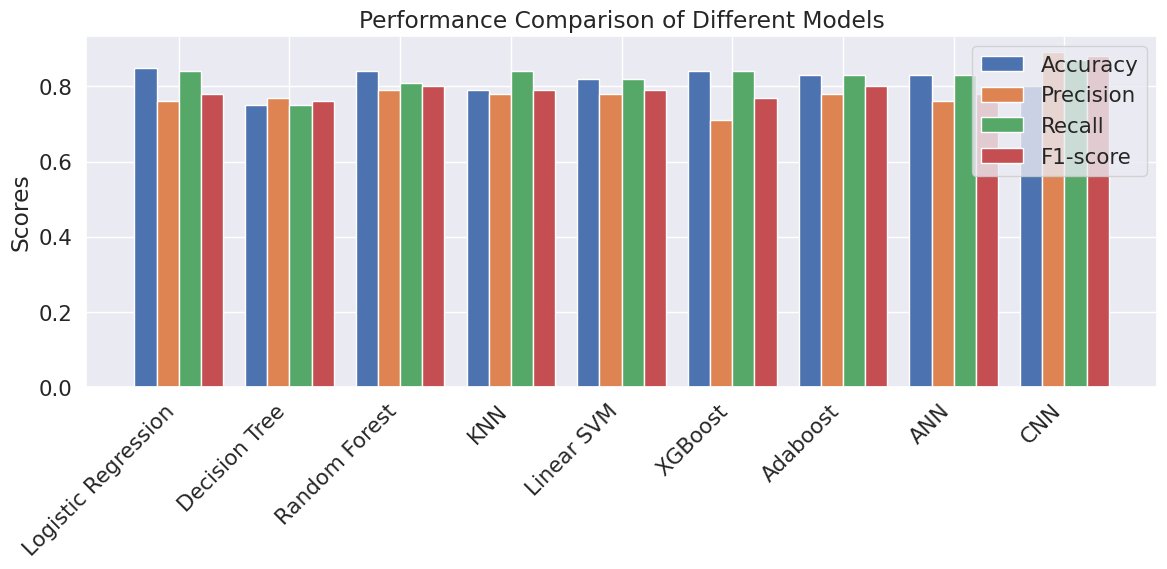

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and performance metrics
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Linear SVM', 'XGBoost', 'Adaboost', 'ANN', 'CNN']

# Sample performance metrics (replace these with your actual metrics)
accuracy = [0.85, 0.75, 0.84, 0.79, 0.82, 0.84, 0.83, 0.83, 0.80]
precision = [0.76, 0.77, 0.79, 0.78, 0.78, 0.71, 0.78, 0.76, 0.89]
recall = [0.84, 0.75, 0.81, 0.84, 0.82, 0.84, 0.83, 0.83, 0.87]
f1_score = [0.78, 0.76, 0.80, 0.79, 0.79, 0.77, 0.80, 0.78, 0.88]

# Plotting
x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 3*width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision, width, label='Precision')
rects3 = ax.bar(x + width/2, recall, width, label='Recall')
rects4 = ax.bar(x + 3*width/2, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Function to attach labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



fig.tight_layout()

plt.show()